# Moneyball Project: UEFA Euro 2020 Fantasy Football
Passion project to leverage data-driven decision making for team selection in [UEFA Euro 2020 Fantasy Football](https://gaming.uefa.com/en/uefaeuro2020fantasyfootball/overview)

## Modelling
-----------------------------
### Purpose
Project points and roi of player for semi final of UEFA Euro 2020

### Author
[Christian Wibisono](https://github.com/christianwbsn)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

%matplotlib inline

import pulp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, precision_score
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from IPython.display import display

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row',50)

In [2]:
DATA_DIR = '../data'

In [3]:
data = pd.read_csv("{}/processed/dataset_md6.csv".format(DATA_DIR))

In [4]:
map_position = {
    "Daniel Bachmann": "GK",
    "Jack Grealish"  : "M",
    "Karim Benzema"  : "F",
    "Maarten Stekelenburg": "GK",
    "Aymeric Laporte": "D",
    "Rafa Silva": "M",
    "Gareth Bale": "M",
    "Joshua Kimmich": "M",
    "Federico Chiesa": "M"
}

In [5]:
data["position"] = data.apply(lambda x: map_position[x["player"]] if x["player"] in map_position.keys() else x["position"], axis=1)

In [6]:
data = data[data["position"] != "0"]

In [7]:
train = data[~pd.isnull(data["points"])]
train["roi"] = train["roi"].fillna(0)
test = data[pd.isnull(data["points"])]
test = test.drop_duplicates(subset=["player", "date"], keep="first")
test = test[~pd.isnull(test["opponent_name"])]
test = test.reset_index(drop=True)

<ipython-input-7-c966e153eef4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["roi"] = train["roi"].fillna(0)


In [8]:
eval_last_md = train[(train["league_name"] == "European Championship 2020") & (train["date"] >= "2021-07-02")]

In [9]:
eval_last_md = eval_last_md.sort_values(by=["points"], ascending=False)

In [10]:
eval_last_md[eval_last_md["position"] == "GK"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
4163,Jordan Pickford,2021-07-03 21:00:00,European Championship 2020,England,Ukraine,0.0,90.0,GK,2021.0,7.0,3.0,6.0,0.0,5.8,1.0,7.0,0.0,0.0,5.090909,0.0,0.0,7.0,2.071451,0.0,0.0,90.0,1.000000,11.0,0.0,0.0,0.727273,0.090909,1.0,31.0,NaN,NaN,NaN,6.333333,0.577350,7.0,3.0,0.0,0.354839,4.0,4.0,1686.0,22.0,24.0,1514.0,1.0,0.0,2.0,2.0,1.0,1.0,25.4,1.250000e+10,498000000.0,26.4,1.972000e+09,75800000.0,26.0,185.0,77.0,1.0,81.0,84.0,70000.0,1.0,NaN,NaN,NaN,NaN,NaN,GK,1.0,NaN,17.0,19.0,15.0,55.0,20.0,14.0,18.0,16.0,56.0,40.0,53.0,44.0,55.0,80.0,55.0,65.0,77.0,45.0,70.0,13.0,42.0,24.0,18.0,68.0,45.0,64.0,20.0,12.0,81.0,77.0,87.0,77.0,85.0,172.0,-20.0,1.052800e+10,422200000.0,-1.0,True,True,False,3.0,1.034483,False,Medium,Medium
9825,Yann Sommer,2021-07-02 18:00:00,European Championship 2020,Switzerland,Spain,0.0,90.0,GK,2021.0,7.0,2.0,5.0,0.0,5.0,1.0,2.0,0.0,0.0,3.760000,0.0,0.0,14.0,2.989983,0.0,0.0,90.0,0.960000,25.0,0.0,0.0,0.280000,0.160000,4.0,30.0,0.0,14.0,8.0,2.000000,1.000000,3.0,3.0,0.0,0.833333,6.0,13.0,1606.0,6.0,6.0,1648.0,1.0,1.0,2.0,3.0,3.0,1.0,27.0,2.835000e+09,109000000.0,26.5,9.150000e+09,381300000.0,31.0,183.0,79.0,1.0,86.0,86.0,55000.0,3.0,NaN,NaN,NaN,NaN,NaN,GK,1.0,NaN,13.0,13.0,10.0,40.0,8.0,15.0,12.0,13.0,31.0,25.0,48.0,54.0,55.0,84.0,58.0,64.0,73.0,45.0,68.0,12.0,38.0,21.0,15.0,64.0,24.0,57.0,19.0,12.0,80.0,86.0,85.0,87.0,85.0,-42.0,7.0,-6.315000e+09,-272300000.0,0.5,True,False,True,0.0,1.000000,False,Medium,Medium
4680,Kasper Schmeichel,2021-07-03 18:00:00,European Championship 2020,Denmark,Czech Republic,0.0,90.0,GK,2021.0,7.0,3.0,3.0,0.0,5.1,1.0,6.0,0.0,0.0,4.142857,0.0,0.0,7.0,2.368220,0.0,0.0,90.0,0.964286,28.0,0.0,0.0,0.535714,0.178571,5.0,30.0,NaN,NaN,NaN,3.000000,2.645751,6.0,3.0,0.0,0.933333,9.0,10.0,1631.0,40.0,40.0,1458.0,1.0,0.0,3.0,4.0,1.0,3.0,27.7,3.107000e+09,119500000.0,27.4,1.900000e+09,73100000.0,33.0,189.0,89.0,1.0,84.0,84.0,90000.0,2.0,NaN,NaN

In [11]:
eval_last_md[eval_last_md["position"] == "D"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
3418,Harry Maguire,2021-07-03 21:00:00,European Championship 2020,England,Ukraine,0.0,90.0,D,2021.0,7.0,3.0,12.0,1.0,5.6,2.0,5.0,0.0,0.0,4.041667,0.0,0.000000,12.0,3.316352,0.282330,0.000000,90.0,0.916667,24.0,0.083333,0.000000,0.625000,0.125000,3.0,31.0,NaN,NaN,NaN,3.666667,3.214550,6.0,2.0,0.000000,0.774194,4.0,4.0,1686.0,22.0,24.0,1514.0,1.0,0.0,2.0,2.0,1.0,1.0,25.4,1.250000e+10,498000000.0,26.4,1.972000e+09,75800000.0,27.0,194.0,100.0,1.0,82.0,85.0,120000.0,2.0,50.0,53.0,69.0,71.0,82.0,NaN,NaN,85.0,51.0,48.0,86.0,78.0,47.0,71.0,44.0,46.0,82.0,76.0,47.0,53.0,54.0,82.0,55.0,68.0,84.0,76.0,90.0,52.0,84.0,83.0,61.0,71.0,44.0,83.0,83.0,79.0,14.0,16.0,9.0,14.0,9.0,172.0,-20.0,1.052800e+10,422200000.0,-1.0,True,True,False,3.0,2.142857,False,High,High
5404,Luke Shaw,2021-07-03 21:00:00,European Championship 2020,England,Ukraine,0.0,90.0,D,2021.0,7.0,3.0,12.0,1.0,6.2,2.0,9.0,0.0,1.0,5.333333,0.0,0.500000,9.0,3.669696,0.000000,0.547723,90.0,0.833333,6.0,0.000000,0.500000,0.833333,0.500000,3.0,31.0,NaN,NaN,NaN,7.000000,1.732051,9.0,3.0,0.000000,0.193548,4.0,4.0,1686.0,22.0,24.0,1514.0,1.0,0.0,2.0,2.0,1.0,1.0,25.4,1.250000e+10,498000000.0,26.4,1.972000e+09,75800000.0,24.0,181.0,75.0,1.0,81.0,83.0,97000.0,2.0,78.0,53.0,74.0,78.0,80.0,NaN,NaN,78.0,75.0,44.0,78.0,78.0,54.0,78.0,76.0,54.0,69.0,79.0,78.0,78.0,75.0,80.0,74.0,70.0,81.0,76.0,77.0,54.0,82.0,78.0,74.0,75.0,44.0,78.0,81.0,79.0,10.0,12.0,13.0,7.0,7.0,172.0,-20.0,1.052800e+10,422200000.0,-1.0,False,True,False,2.0,1.935484,False,Medium,Medium
4973,Kyle Walker,2021-07-03 21:00:00,European Championship 2020,England,Ukraine,0.0,90.0,D,2021.0,7.0,3.0,6.0,0.0,5.6,2.0,6.0,0.0,0.0,3.473684,0.0,0.052632,9.0,2.524731,0.000000,0.229416,90.0,0.842105,19.0,0.000000,0.052632,0.526316,0.105263,2.0,31.0,NaN,NaN,NaN,4.000000,3.464102,6.0,2.0,0.000000,0.612903,4.0,4.0,1686.0,22.0,24.0,1514.0,1.0,0.0,2.0,2.0,1.0,1.0,25.4,1.250000e+10,498000000.0,

In [12]:
eval_last_md[eval_last_md["position"] == "M"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
5170,Lorenzo Insigne,2021-07-02 21:00:00,European Championship 2020,Italy,Belgium,0.0,90.0,M,2021.0,7.0,2.0,8.0,1.0,8.6,3.0,3.0,0.0,0.0,4.722222,0.0,0.333333,10.0,2.674620,0.427793,0.485071,90.0,0.944444,18.0,0.222222,0.333333,0.777778,0.166667,3.0,31.0,NaN,NaN,NaN,2.000000,1.732051,3.0,2.0,0.000000,0.580645,7.0,7.0,1642.0,1.0,1.0,1783.0,1.0,1.0,0.0,3.0,3.0,2.0,27.8,7.640000e+09,293800000.0,29.2,6.694000e+09,257500000.0,29.0,163.0,59.0,1.0,85.0,85.0,120000.0,3.0,88.0,78.0,83.0,91.0,36.0,LW,10.0,44.0,83.0,75.0,59.0,83.0,74.0,90.0,87.0,77.0,78.0,93.0,92.0,84.0,93.0,80.0,93.0,78.0,50.0,70.0,34.0,84.0,34.0,26.0,81.0,85.0,74.0,83.0,24.0,22.0,8.0,4.0,14.0,9.0,10.0,-141.0,6.0,9.460000e+08,36300000.0,-1.4,True,False,True,0.0,0.930233,False,High,Medium
6779,Nicolò Barella,2021-07-02 21:00:00,European Championship 2020,Italy,Belgium,0.0,90.0,M,2021.0,7.0,2.0,7.0,0.0,7.3,3.0,2.0,0.0,0.0,3.600000,0.0,0.160000,9.0,2.500000,0.374166,0.472582,90.0,0.880000,25.0,0.160000,0.120000,0.640000,0.080000,2.0,31.0,NaN,NaN,NaN,2.666667,3.055050,6.0,2.0,0.000000,0.806452,7.0,7.0,1642.0,1.0,1.0,1783.0,1.0,1.0,0.0,3.0,3.0,2.0,27.8,7.640000e+09,293800000.0,29.2,6.694000e+09,257500000.0,23.0,175.0,68.0,1.0,80.0,87.0,86000.0,2.0,78.0,67.0,79.0,82.0,74.0,RCM,18.0,72.0,76.0,63.0,40.0,82.0,65.0,83.0,75.0,67.0,78.0,83.0,80.0,76.0,78.0,79.0,83.0,72.0,62.0,87.0,62.0,66.0,82.0,79.0,75.0,79.0,73.0,80.0,80.0,78.0,11.0,5.0,13.0,14.0,11.0,-141.0,6.0,9.460000e+08,36300000.0,-1.4,False,False,True,7.0,0.958904,False,Medium,High
9798,Xherdan Shaqiri,2021-07-02 18:00:00,European Championship 2020,Switzerland,Spain,0.0,90.0,M,2021.0,7.0,2.0,7.0,1.0,7.6,3.0,2.0,0.0,0.0,3.842105,0.0,0.263158,13.0,3.370842,0.535303,0.561951,80.0,0.842105,19.0,0.157895,0.210526,0.157895,0.157895,3.0,30.0,0.0,2.0,1.5,5.666667,6.350853,13.0,3.0,0.666667,0.633333,6.0,13.0,1606.0,6.0,6.0,1648.0,1.0,1.0,2.0,3.0,3.0,1.0,27.0,2.835000e+09,109000000

In [13]:
eval_last_md[eval_last_md["position"] == "F"].head(10)

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
3392,Harry Kane,2021-07-03 21:00:00,European Championship 2020,England,Ukraine,0.0,90.0,F,2021.0,7.0,3.0,10.0,0.0,11.6,4.0,6.0,1.0,0.0,5.111111,0.0,0.333333,17.0,4.326424,0.843949,0.733799,90.0,0.888889,27.0,0.444444,0.222222,0.518519,0.111111,3.0,31.0,NaN,NaN,NaN,3.333333,2.309401,6.0,3.0,0.333333,0.870968,4.0,4.0,1686.0,22.0,24.0,1514.0,1.0,0.0,2.0,2.0,1.0,1.0,25.4,1.250000e+10,498000000.0,26.4,1.972000e+09,75800000.0,26.0,188.0,89.0,1.0,88.0,89.0,220000.0,3.0,68.0,91.0,80.0,80.0,47.0,ST,9.0,83.0,75.0,94.0,85.0,81.0,85.0,80.0,80.0,68.0,83.0,84.0,66.0,69.0,69.0,90.0,73.0,91.0,79.0,84.0,84.0,86.0,81.0,35.0,93.0,83.0,90.0,91.0,36.0,38.0,8.0,10.0,11.0,14.0,11.0,172.0,-20.0,1.052800e+10,422200000.0,-1.0,True,True,False,1.0,0.862069,False,High,High
7181,Patrik Schick,2021-07-03 18:00:00,European Championship 2020,Czech Republic,Denmark,0.0,90.0,F,2021.0,7.0,3.0,6.0,0.0,8.8,4.0,6.0,1.0,0.0,4.666667,1.0,0.111111,12.0,3.865382,0.685994,0.471405,80.5,0.888889,18.0,0.555556,0.055556,0.222222,0.277778,5.0,30.0,NaN,NaN,NaN,5.333333,3.055050,8.0,3.0,0.666667,0.600000,40.0,40.0,1458.0,9.0,10.0,1631.0,0.0,1.0,3.0,1.0,4.0,3.0,27.4,1.900000e+09,73100000.0,27.7,3.107000e+09,119500000.0,24.0,186.0,73.0,1.0,78.0,84.0,55000.0,2.0,70.0,76.0,71.0,81.0,37.0,ST,19.0,67.0,64.0,79.0,80.0,78.0,74.0,82.0,78.0,56.0,62.0,83.0,71.0,70.0,83.0,76.0,67.0,74.0,68.0,64.0,72.0,74.0,59.0,25.0,80.0,73.0,58.0,73.0,24.0,19.0,11.0,15.0,8.0,9.0,14.0,-173.0,30.0,-1.207000e+09,-46400000.0,-0.3,False,True,False,6.0,0.681818,False,Medium,Medium
8082,Romelu Lukaku,2021-07-02 21:00:00,European Championship 2020,Belgium,Italy,0.0,90.0,F,2021.0,7.0,2.0,6.0,0.0,11.4,4.0,2.0,0.0,0.0,6.900000,1.0,0.200000,13.0,3.416677,0.788069,0.410391,90.0,1.000000,20.0,0.750000,0.200000,0.500000,0.250000,5.0,31.0,NaN,NaN,NaN,3.333333,2.309401,6.0,3.0,0.333333,0.645161,1.0,1.0,1783.0,7.0,7.0,1642.0,1.0,1.0,0.0,3.0,3.0,2.0,29.2,6.694000e+09,2

In [14]:
train.shape

(9319, 123)

In [15]:
test.shape

(94, 123)

In [16]:
train.head()

,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate
0,Aaron Ramsey,2018-09-06 00:00:00,UEFA Nations League,Wales,Republic of Ireland,21.00,90.0,M,2018.0,9.0,6.0,7.0,0.0,8.7,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18.0,19.0,1536.0,26.0,29.0,1484.0,0.0,2.0,2.0,0.0,4.0,3.0,25.6,1.767500e+09,68000000.0,25.5,7.765000e+08,29900000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,52.0,-10.0,9.910000e+08,38100000.0,0.1,True,True,False,1.0,0.804598,False,High,High
1,Aaron Ramsey,2018-09-09 00:00:00,UEFA Nations League,Wales,Denmark,13.50,90.0,M,2018.0,9.0,9.0,2.0,0.0,8.7,3.0,7.0,1.0,0.0,7.000000,1.0,0.0,7.0,0.000000,0.000000,0.0,90.0,1.0,1.0,1.000000,0.0,0.0,0.0,0.0,1.0,NaN,NaN,NaN,7.0,0.0,7.0,3.0,1.0,1.00,18.0,19.0,1536.0,9.0,9.0,1580.0,0.0,0.0,0.0,0.0,0.0,NaN,25.6,1.767500e+09,68000000.0,27.8,3.107000e+09,119500000.0,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75.0,81.0,70.0,67.0,6.0,11.0,5.0,10.0,8.0,-44.0,10.0,-1.339500e+09,-51500000.0,-2.2,True,True,False,1.0,0.229885,False,High,High
2,Aaron Ramsey,2018-10-11 00:00:00,International Friendlies,Wales,Spain,1.42,90.0,M,2018.0,10.0,11.0,2.0,0.0,8.7,3.0,2.0,0.0,0.0,4.500000,0.5,0.0,7.0,2.672612,0.534522,0.0,90.0,1.0,2.0,0.500000,0.0,0.0,0.0,0.0,2.0,NaN,NaN,NaN,2.0,0.0,2.0,3.0,0.0,1.00,18.0,19.0,1536.0,6.0,9.0,1597.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.0,183.0,76.0,1.0,82.0,83.0,130000.0,3.0,68.0,75.0,79.0,81.0,65.0,RF,10.0,75.0,75.0,72.0,58.0,84.0,79.0,81.0,70.0,70.0,80.0,82.0,67.0,68.0,76.0,81.0,75.0,81.0,67.0,89.0,69.0,74.0,73.0,69.0,82.0,80.0,75

In [17]:
train.columns

Index(['player', 'date', 'league_name', 'team_name', 'opponent_name',
       'fantasy_points', 'min', 'position', 'year', 'month',
       ...
       'diff_team_mean_market_value', 'diff_team_mean_squad_age', 'is_senior',
       'is_imbalanced', 'big_match', 'gap_to_potential', 'roi',
       'more_likely_to_win', 'attacking_work_rate', 'defending_work_rate'],
      dtype='object', length=123)

In [18]:
def train_model(df, dropped_cols, label, model, need_fillna):
    train = df[df["league_name"] != "European Championship 2020"]
    test = df[df["league_name"] == "European Championship 2020"]
    X_train = pd.get_dummies(train.drop(dropped_cols, axis=1))
    X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))
    if need_fillna:
        X_train = X_train.fillna(0)
        X_test = X_test.fillna(0)
    y_train = train[label]
    y_test  = test[label]
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    mae, mse = mean_absolute_error(y_test, prediction), mean_squared_error(y_test, prediction)
    print(model)
    print("MAE:", mae)
    print("MSE:", mse)

In [19]:
fifa_col = ['attacking_crossing','attacking_heading_accuracy', 'attacking_short_passing',
            'attacking_volleys', 'skill_dribbling', 'skill_curve', 'height_cm', 'weight_kg',
            'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
            'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
            'movement_reactions', 'movement_balance', 'power_shot_power',
            'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
            'mentality_aggression', 'mentality_interceptions',
            'mentality_positioning', 'mentality_vision', 'mentality_penalties',
            'mentality_composure', 'defending_standing_tackle',
            'defending_sliding_tackle', 'goalkeeping_diving',
            'goalkeeping_handling', 'goalkeeping_kicking',
            'goalkeeping_positioning', 'goalkeeping_reflexes', 'attacking_finishing']

In [20]:
dropped_cols = ['player', 'league_name', 'date', 'year','points', 'is_star_of_match',
                'roi', 'value', 'min', 'nation_position', 'age', 'month', 'day',
                'nation_jersey_number','team_name', 'opponent_name', 'last_md_points',
                'fantasy_points', 'prev_median_min', "prev_std_goals",
                "prev_team_highest_rank" , "prev_opponent_highest_rank", 
                "is_senior", "hth_draw", 'last_md_goals', 'last_md_assists']

In [21]:
dropped_cols += fifa_col

Need to find sweet spot between player consistency and speculation (The Mavericks) --> player with high volatility of points [http://www.frontier-economics.com/uk/en/news-and-articles/articles/article-i7337-how-to-win-your-fantasy-football-league/] 
* roi -> measuring value for money (find undervalued player)
* points --> measuring player consistency

In [22]:
model_roi = RandomForestRegressor(random_state=1)
train_model(train, dropped_cols, "roi", model_roi, True)

RandomForestRegressor(random_state=1)
MAE: 0.4207163005622642
MSE: 0.2371515369727931


In [23]:
model_points = LGBMRegressor(random_state=1)
train_model(train, dropped_cols, "points", model_points, False)

LGBMRegressor(random_state=1)
MAE: 2.2074837432650027
MSE: 6.762694987027424


## The Dream Team

In [24]:
X_test = pd.get_dummies(test.drop(dropped_cols, axis=1))

In [25]:
def plotImp(model, X , num =20, fig_size = (9, 3)):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=fig_size)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(str(model) +' Features')
    plt.tight_layout()
    plt.show()

In [26]:
def get_model(df, dropped_cols, label, model, need_fillna):
    X = pd.get_dummies(df.drop(dropped_cols, axis=1))
    if need_fillna:
        X = X.fillna(0)
    y = df[label]
    model.fit(X, y)
    print(X.columns)
    plotImp(model,X, 10)
    return model

Index(['skill', 'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_std_assists',
       'prev_ratio_starter', 'count_played', 'goal_consistency',
       'assist_consistency', 'clean_sheet_consistency',
       'star_of_match_consistency', 'star_of_match_count', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'last_three_match_mean_points',
       'last_three_match_std_points', 'last_three_match_max_points',
       'last_three_match_significant_min_play', 'last_three_match_goal_rate',
       'prev_ratio_played', 'team_rank', 'team_total_points', 'opponent_rank',
       'opponent_total_points', 'hth_team_win', 'hth_opp_win',
       'hth_team_score', 'hth_opp_score', 'htt_max_margin',
       'team_mean_squad_age', 'team_market_value', 'team_mean_market_value',
       'opponent_mean_squad_age', 'opponent_market_value',
       'opponent_mean_m

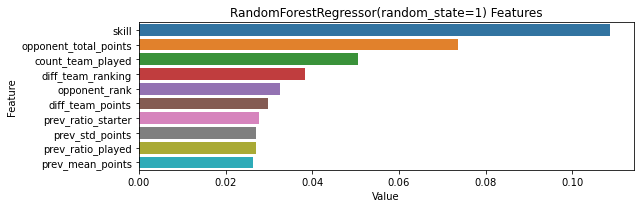

Index(['skill', 'prev_mean_points', 'prev_mean_goals', 'prev_mean_assists',
       'prev_max_points', 'prev_std_points', 'prev_std_assists',
       'prev_ratio_starter', 'count_played', 'goal_consistency',
       'assist_consistency', 'clean_sheet_consistency',
       'star_of_match_consistency', 'star_of_match_count', 'count_team_played',
       'prev_max_goal_to_specific_opp', 'prev_max_points_to_specific_opp',
       'prev_mean_points_to_specific_opp', 'last_three_match_mean_points',
       'last_three_match_std_points', 'last_three_match_max_points',
       'last_three_match_significant_min_play', 'last_three_match_goal_rate',
       'prev_ratio_played', 'team_rank', 'team_total_points', 'opponent_rank',
       'opponent_total_points', 'hth_team_win', 'hth_opp_win',
       'hth_team_score', 'hth_opp_score', 'htt_max_margin',
       'team_mean_squad_age', 'team_market_value', 'team_mean_market_value',
       'opponent_mean_squad_age', 'opponent_market_value',
       'opponent_mean_m

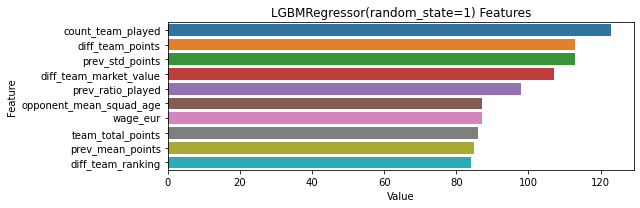

In [27]:
model_1 = get_model(train, dropped_cols, 'roi', model_roi, True)
model_2 = get_model(train, dropped_cols, 'points', model_points, False)

In [28]:
import shap
shap.initjs()

In [29]:
explainer = shap.Explainer(model_2)
shap_obj = explainer(X_test)

In [30]:
def player_to_watch(shap_obj, df, player_name):
    print("Evaluating points for: ", player_name)
    player = df[(df["player"] == player_name)][:1]
    display(player)
    shap.plots.waterfall(shap_obj[player.index[0]])

In [31]:
X_test

,skill,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_assists,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,team_rank,team_total_points,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,physic,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_imbalanced,big_match,gap_to_potential,more_likely_to_win,position_D,position_F,position_GK,position_M,attacking_work_rate_High,attacking_work_rate_Low,attacking_work_rate_Medium,defending_work_rate_High,defending_work_rate_Low,defending_work_rate_Medium
0,3.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,5.0,0.000000,0.000000,1.000000,0.000000,0.0,32.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.15625,4.0,1686.0,10.0,1631.0,2.0,1.0,3.0,2.0,1.0,25.4,1.250000e+10,498000000.0,27.7,3.107000e+09,119500000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,-6.0,9.393000e+09,378500000.0,-2.3,False,True,NaN,False,0,0,0,1,0,0,0,0,0,0
1,3.0,0.700000,0.0,0.000000,2.0,0.674949,0.000000,0.100000,10.0,0.000000,0.000000,0.400000,0.000000,0.0,32.0,NaN,NaN,NaN,0.333333,0.577350,1.0,1.0,0.000000,0.31250,6.0,1648.0,7.0,1642.0,3.0,2.0,12.0,7.0,4.0,26.5,9.150000e+09,381300000.0,27.8,7.640000e+09,293800000.0,1.0,79.0,85.0,80000.0,1.0,96.0,66.0,68.0,87.0,38.0,81.0,6.0,-1.0,1.510000e+09,87500000.0,-1.3,False,True,6.0,False,0,0,0,1,1,0,0,0,1,0
2,2.0,3.333333,0.0,0.000000,6.0,3.162278,0.000000,0.555556,9.0,0.000000,0.000000,1.000000,0.222222,2.0,32.0,NaN,NaN,NaN,2.000000,3.464102,6.0,1.0,0.000000,0.28125,7.0,1642.0,6.0,1648.0,2.0,3.0,7.0,12.0,4.0,27.8,7.640000e+09,293800000.0,26.5,9.150000e+09,381300000.0,1.0,75.0,83.0,46000.0,1.0,62.0,33.0,52.0,54.0,78.0,68.0,-6.0,1.0,-1.510000e+09,-87500000.0,1.3,False,True,8.0,False,1,0,0,0,0,0,1,0,0,1
3,2.0,3.421053,0.0,0.105263,9.0,2.892822,0.315302,0.631579,19.0,0.000000,0.105263,0.684211,0.210526,4.0,32.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.59375,7.0,1642.0,6.0,1648.0,2.0,3.0,7.0,12.0,4.0,27.8,7.640000e+09,293800000.0,26.5,9.150000e+09,381300000.0,1.0,81.0,81.0,84000.0,3.0,81.0,77.0,76.0,79.0,77.0,73.0,-6.0,1.0,-1.510000e+09,-87500000.0,1.3,False,True,0.0,False,1,0,0,0,1,0,0,1,0,0
4,1.0,0.166667,0.0,0.000000,1.0,0.408248,0.000000,0.000000,6.0,0.000000,0.000000,0.833333,0.000000,0.0,32.0,NaN,NaN,NaN,0.000000,0.000000,0.0,0.0,0.000000,0.18750,7.0,1642.0,6.0,1648.0,2.0,3.0,7.0,12.0,4.0,27.8,7.640000e+09,293800000.0,26.5,9.150000e+09,381300000.0,1.0,78.0,87.0,36000.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,-6.0,1.0,-1.510000e+09,-87500000.0,1.3,False,True,9.0,False,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,3.0,2.923077,0.0,0.076923,9.0,1.998461,0.392232,0.961538,26.0,0.076923,0.038462,0.423077,0.038462,1.0,31.0,0.0,3.0,3.0,3.666667,3.055050,7.0,3.0,0.333333,0.83871,10.0,1631.0,4.0,1686.0,1.0,2.0,2.0,3.0,1.0,27.7,3.107000e+09,119500000.0,25.4,1.250000e+10,498000000.0,1.0,81.0,81.0,63000.0,2.0,77.0,73.0,73.0,74.0,82.0,82.0,-55.0,6.0,-9.393000e+09,-378500000.0,2.3,False,True,0.0,False,0,0,0,1,0,1,0,1,0,0
90,2.0,2.923077,0.0,0.076923,6.0,2.722179,0.27

In [32]:
test["predicted_roi"] = model_1.predict(X_test.fillna(0))
test["predicted_points"] = model_2.predict(X_test)

## Surfacing The Result

In [33]:
injured = ["Christian Eriksen"]

In [34]:
fantasy_euro = pd.read_csv("{}/interim/fantasy_euro.csv".format(DATA_DIR))

In [35]:
fantasy_euro = fantasy_euro[["player", "date", "league_name", "team_name", 
                             "opponent_name", "value", "skill", "sel_per"]]

In [36]:
players = pd.merge(test, 
                   fantasy_euro[["player", "sel_per"]],
                   how='left', on="player")

In [37]:
players = players.drop_duplicates(subset=["player", "team_name"])

In [38]:
players["player"] = players["player"].apply(lambda x: re.sub("-", " ", x))

In [39]:
players = players[players['position'] != "0"]
players = players[~players['player'].isin(injured)]

In [40]:
players = players[players["prev_ratio_played"] > 0.1]

In [41]:
scaler = StandardScaler()
players["scaled_points"] = scaler.fit_transform(players["predicted_points"].values.reshape(-1,1))
players["scaled_roi"] = scaler.fit_transform(players["predicted_roi"].values.reshape(-1,1))

In [42]:
players["final_score"] = players["scaled_points"] * 0.8 + players["scaled_roi"] * 0.2

In [43]:
players = players.sort_values(by=["final_score"], ascending=False)

In [44]:
players["match"] = players["team_name"] + ',' + players['opponent_name']
players["match"] = players["match"].apply(lambda x: ' '.join(sorted(x.split(","))))

In [45]:
players["field"] = players["position"].apply(lambda x: "DEF" if x in ["GK", "D"] else "ATTACK")

In [46]:
col = ["player", "team_name", "opponent_name", "position", "value", "predicted_roi", "predicted_points", "final_score", "last_md_points", "prev_max_points", "prev_mean_points", "prev_std_points",'clean_sheet_consistency', 'sel_per']

In [47]:
views = players[col]

In [48]:
views.head(50)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
85,Raheem Sterling,England,Denmark,M,9.8,0.564102,4.955240,3.091880,6.0,18.0,6.863636,4.853035,0.636364,40
65,Luke Shaw,England,Denmark,D,6.2,0.734817,4.470134,2.908903,12.0,12.0,6.285714,4.191829,0.857143,26
51,Jordan Pickford,England,Denmark,GK,5.8,0.767190,3.678785,2.308564,6.0,7.0,5.166667,1.992410,0.750000,27
61,Kyle Walker,England,Denmark,D,5.6,0.535603,3.887572,2.193397,6.0,9.0,3.600000,2.521487,0.550000,15
64,Lorenzo Insigne,Italy,Spain,M,8.6,0.533694,3.695773,2.035930,8.0,10.0,4.894737,2.705852,0.789474,28
40,Harry Kane,England,Denmark,F,11.6,0.500120,3.645814,1.954345,10.0,17.0,5.285714,4.344917,0.535714,39
48,John Stones,England,Denmark,D,5.8,0.644071,3.061128,1.658003,6.0,6.0,4.071429,2.432608,0.571429,31
78,Nicolò Barella,Italy,Spain,M,7.3,0.622855,2.597317,1.256852,7.0,9.0,3.730769,2.538625,0.653846,6
33,Ferran Torres,Spain,Italy,M,8.2,0.439428,2.677210,1.096502,2.0,18.0,4.733333,4.589844,0.400000,19
41,Harry Maguire,England,Denmark,D,5.6,0.528040,2.470318,1.037848,12.0,12.0,4.360000,3.615706,0.640000,8


## Goalkeeper

In [49]:
views[views["position"] == "GK"]

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
51,Jordan Pickford,England,Denmark,GK,5.8,0.767190,3.678785,2.308564,6.0,7.0,5.166667,1.992410,0.750000,27
58,Kasper Schmeichel,Denmark,England,GK,5.1,0.460845,2.443602,0.933827,3.0,7.0,4.103448,2.335209,0.517241,15
37,Gianluigi Donnarumma,Italy,Spain,GK,5.8,0.502941,2.368768,0.924931,2.0,7.0,4.791667,2.021174,0.708333,46
95,Unai Simón,Spain,Italy,GK,5.3,0.385024,2.030028,0.506337,2.0,6.0,3.181818,1.834022,0.454545,8
89,Salvatore Sirigu,Italy,Spain,GK,4.5,0.018247,0.471214,-1.204270,0.0,7.0,3.307692,2.897833,0.846154,1
23,David de Gea,Spain,Italy,GK,5.5,0.085263,0.350713,-1.219539,0.0,6.0,2.470588,2.348341,0.470588,3
5,Alex Meret,Italy,Spain,GK,4.5,0.007204,0.295473,-1.359953,0.0,1.0,0.166667,0.408248,0.833333,0
35,Frederik Rönnow,Denmark,England,GK,4.5,0.016138,0.072983,-1.528946,0.0,6.0,1.000000,2.236068,0.142857,0


Evaluating points for:  Gianluigi Donnarumma


,player,date,league_name,team_name,opponent_name,fantasy_points,min,position,year,month,day,points,is_star_of_match,value,skill,last_md_points,last_md_goals,last_md_assists,prev_mean_points,prev_mean_goals,prev_mean_assists,prev_max_points,prev_std_points,prev_std_goals,prev_std_assists,prev_median_min,prev_ratio_starter,count_played,goal_consistency,assist_consistency,clean_sheet_consistency,star_of_match_consistency,star_of_match_count,count_team_played,prev_max_goal_to_specific_opp,prev_max_points_to_specific_opp,prev_mean_points_to_specific_opp,last_three_match_mean_points,last_three_match_std_points,last_three_match_max_points,last_three_match_significant_min_play,last_three_match_goal_rate,prev_ratio_played,prev_team_highest_rank,team_rank,team_total_points,prev_opponent_highest_rank,opponent_rank,opponent_total_points,hth_team_win,hth_opp_win,hth_draw,hth_team_score,hth_opp_score,htt_max_margin,team_mean_squad_age,team_market_value,team_mean_market_value,opponent_mean_squad_age,opponent_market_value,opponent_mean_market_value,age,height_cm,weight_kg,league_rank,overall,potential,wage_eur,international_reputation,pace,shooting,passing,dribbling,defending,nation_position,nation_jersey_number,physic,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,diff_team_points,diff_team_ranking,diff_team_market_value,diff_team_mean_market_value,diff_team_mean_squad_age,is_senior,is_imbalanced,big_match,gap_to_potential,roi,more_likely_to_win,attacking_work_rate,defending_work_rate,predicted_roi,predicted_points
34,Gianluigi Donnarumma,2021-07-06 21:00:00,European Championship 2020,Italy,Spain,NaN,NaN,GK,2021.0,7.0,6.0,NaN,NaN,5.8,1.0,2.0,0.0,0.0,4.791667,0.0,0.0,7.0,2.021174,0.0,0.0,90.0,1.0,24.0,0.0,0.0,0.708333,0.166667,4.0,32.0,NaN,NaN,NaN,3.333333,2.309401,6.0,3.0,0.0,0.75,7.0,7.0,1642.0,6.0,6.0,1648.0,2.0,3.0,4.0,7.0,12.0,4.0,27.8,7.640000e+09,293800000.0,26.5,9.150000e+09,381300000.0,21.0,196.0,90.0,1.0,85.0,92.0,34000.0,3.0,NaN,NaN,NaN,NaN,NaN,GK,21.0,NaN,12.0,12.0,12.0,34.0,8.0,28.0,12.0,14.0,24.0,28.0,46.0,54.0,64.0,79.0,38.0,57.0,72.0,34.0,72.0,18.0,30.0,26.0,14.0,50.0,24.0,68.0,14.0,16.0,89.0,81.0,76.0,83.0,89.0,-6.0,1.0,-1.510000e+09,-87500000.0,1.3,False,False,True,7.0,NaN,False,Medium,Medium,0.502941,2.368768


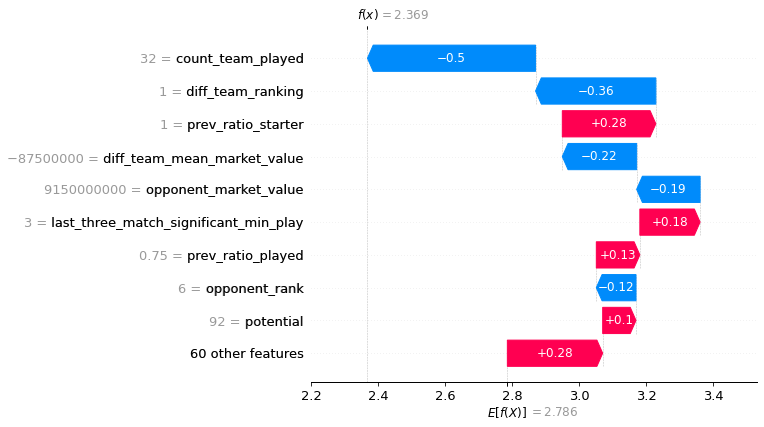

In [50]:
player_to_watch(shap_obj, test, "Gianluigi Donnarumma")

## Defender

In [51]:
views[(views["position"] == "D")].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
65,Luke Shaw,England,Denmark,D,6.2,0.734817,4.470134,2.908903,12.0,12.0,6.285714,4.191829,0.857143,26
61,Kyle Walker,England,Denmark,D,5.6,0.535603,3.887572,2.193397,6.0,9.0,3.600000,2.521487,0.550000,15
48,John Stones,England,Denmark,D,5.8,0.644071,3.061128,1.658003,6.0,6.0,4.071429,2.432608,0.571429,31
41,Harry Maguire,England,Denmark,D,5.6,0.528040,2.470318,1.037848,12.0,12.0,4.360000,3.615706,0.640000,8
59,Kieran Trippier,England,Denmark,D,5.2,0.434940,2.112880,0.634568,1.0,6.0,3.277778,2.539235,0.555556,4
19,César Azpilicueta,Spain,Italy,D,5.3,0.299436,2.233531,0.565960,2.0,7.0,2.375000,2.669270,0.500000,7
52,Jordi Alba,Spain,Italy,D,6.3,0.410691,1.968641,0.488167,5.0,8.0,4.545455,2.583162,0.454545,21
62,Leonardo Bonucci,Italy,Spain,D,5.7,0.303424,2.033605,0.409150,2.0,12.0,4.538462,2.686719,0.653846,19
47,Joakim Maehle,Denmark,England,D,4.9,0.521521,1.606959,0.331567,5.0,12.0,6.571429,4.391550,0.285714,23
91,Simon Kjaer,Denmark,England,D,4.7,0.302990,1.714074,0.150182,2.0,9.0,3.785714,2.454884,0.428571,13


## Midfielder

In [52]:
views[(views["position"] == "M")].head(30)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
85,Raheem Sterling,England,Denmark,M,9.8,0.564102,4.955240,3.091880,6.0,18.0,6.863636,4.853035,0.636364,40
64,Lorenzo Insigne,Italy,Spain,M,8.6,0.533694,3.695773,2.035930,8.0,10.0,4.894737,2.705852,0.789474,28
78,Nicolò Barella,Italy,Spain,M,7.3,0.622855,2.597317,1.256852,7.0,9.0,3.730769,2.538625,0.653846,6
33,Ferran Torres,Spain,Italy,M,8.2,0.439428,2.677210,1.096502,2.0,18.0,4.733333,4.589844,0.400000,19
56,Kalvin Phillips,England,Denmark,M,5.4,0.529456,2.213053,0.831508,3.0,6.0,2.750000,1.288057,0.750000,9
60,Koke,Spain,Italy,M,7.4,0.386723,2.314865,0.738797,2.0,5.0,2.818182,1.537412,0.454545,2
67,Marco Verratti,Italy,Spain,M,6.8,0.412984,2.268887,0.733818,4.0,8.0,2.900000,2.149663,0.800000,2
93,Thomas Delaney,Denmark,England,M,5.5,0.361710,2.268214,0.670387,7.0,9.0,2.923077,1.998461,0.423077,1
42,Jack Grealish,England,Denmark,M,7.8,0.292652,2.365774,0.664597,0.0,6.0,2.200000,2.683282,1.000000,11
53,Jorginho,Italy,Spain,M,6.3,0.343236,2.190291,0.584706,2.0,10.0,3.571429,2.622808,0.642857,5


## Forward

In [53]:
views[views["position"] == "F"].head(20)

,player,team_name,opponent_name,position,value,predicted_roi,predicted_points,final_score,last_md_points,prev_max_points,prev_mean_points,prev_std_points,clean_sheet_consistency,sel_per
40,Harry Kane,England,Denmark,F,11.6,0.500120,3.645814,1.954345,10.0,17.0,5.285714,4.344917,0.535714,39
70,Martin Braithwaite,Denmark,England,F,7.7,0.395304,2.610175,0.988167,2.0,6.0,3.103448,1.739146,0.413793,3
17,Ciro Immobile,Italy,Spain,F,10.2,0.264675,2.652114,0.861876,2.0,13.0,3.944444,3.438061,0.611111,39
57,Kasper Dolberg,Denmark,England,F,7.2,0.244123,2.380917,0.617325,5.0,13.0,3.090909,3.986992,0.272727,5
96,Yussuf Poulsen,Denmark,England,F,8.5,0.357804,1.975123,0.428545,1.0,6.0,2.653846,1.742236,0.384615,4
97,Álvaro Morata,Spain,Italy,F,9.1,0.330411,1.919252,0.349760,1.0,10.0,3.238095,2.662795,0.428571,17
75,Mikel Oyarzabal,Spain,Italy,F,7.6,0.235261,1.805478,0.141042,1.0,6.0,2.647059,1.966633,0.352941,1
6,Andrea Belotti,Italy,Spain,F,7.9,0.188247,1.474200,-0.184556,1.0,10.0,3.105263,3.413938,0.631579,1
36,Gerard Moreno,Spain,Italy,F,6.9,0.215243,1.273378,-0.313871,2.0,15.0,3.800000,3.895052,0.466667,8
43,Jadon Sancho,England,Denmark,F,9.5,0.189886,1.265938,-0.350989,3.0,10.0,2.545455,3.077780,0.636364,1


## Selecting the Team

In [54]:
players = players.reset_index(drop=True)

In [67]:
def make_decision_variables(player_df):
    return [pulp.LpVariable(i, cat="Binary") for i in player_df.player]

In [68]:
def make_optimization_function(player_df, decision_variables):
    op_func = ""

    for i, player in enumerate(decision_variables):
        op_func += player_df.final_score[i]*player
        
    return op_func

In [69]:
def make_cash_constraint(player_df, decision_variables, available_cash):
    total_paid = ""
    for rownum, row in player_df.iterrows():
        for i, player in enumerate(decision_variables):
            if rownum == i:
                total_paid += row.value*player

    return (total_paid <= available_cash)

In [70]:
def make_player_constraint(position, n, decision_variables, player_df):
    
    total_n = ""
    
    player_positions = player_df.position
    
    for i, player in enumerate(decision_variables):
        if player_positions[i] == position:
            total_n += 1*player
            
    return(total_n == n)

In [71]:
def add_team_constraint(prob, player_df, decision_variables):

    for team, group in player_df.groupby('team_name'):
        team_total = ''
        for player in decision_variables:
            if re.sub("_", " ", player.name) in group.player.values:
                formula = 1*player
                team_total += formula

        prob += (team_total <= 4)

In [72]:
def add_match_constraint(prob, player_df, decision_variables):

    for team, group in player_df.groupby('match'):
        team_total = ''
        for player in decision_variables:
            if re.sub("_", " ", player.name) in group.player.values:
                formula = 1*player
                team_total += formula

        prob += (team_total <= 8)

In [73]:
available_cash = 105

prob = pulp.LpProblem('semifinal', pulp.LpMaximize)

decision_variables = make_decision_variables(players)
prob += make_optimization_function(players, decision_variables)
prob += make_cash_constraint(players, decision_variables, available_cash)
prob += make_player_constraint("GK", 2, decision_variables, players) 
prob += make_player_constraint("D", 5, decision_variables, players) 
prob += make_player_constraint("M", 5, decision_variables, players) 
prob += make_player_constraint("F", 3, decision_variables, players)
add_team_constraint(prob, players, decision_variables)
add_match_constraint(prob, players, decision_variables)

In [74]:
prob.writeLP('semifinal.lp')
optimization_result = prob.solve()

In [75]:
def get_initial_team(prob, player_df):
    
    variable_names = [re.sub("_", " ", v.name) for v in prob.variables()]
    variable_values = [v.varValue for v in prob.variables()]
    
    initial_team = pd.merge(pd.DataFrame({'player': variable_names,
                                          'selected': variable_values}),
                                           player_df, on="player")
    
    initial_team = initial_team[initial_team.selected==1.0] 
    
    return initial_team

In [76]:
initial_team_df = get_initial_team(prob, players)
initial_team_df[['player', "position", "value", "team_name", "predicted_points"]].sort_values("position")

,player,position,value,team_name,predicted_points
16,César Azpilicueta,D,5.3,Spain,2.233531
48,Jordi Alba,D,6.3,Spain,1.968641
57,Kyle Walker,D,5.6,England,3.887572
58,Leonardo Bonucci,D,5.7,Italy,2.033605
61,Luke Shaw,D,6.2,England,4.470134
14,Ciro Immobile,F,10.2,Italy,2.652114
53,Kasper Dolberg,F,7.2,Denmark,2.380917
66,Martin Braithwaite,F,7.7,Denmark,2.610175
47,Jordan Pickford,GK,5.8,England,3.678785
54,Kasper Schmeichel,GK,5.1,Denmark,2.443602


In [77]:
initial_team_df["value"].sum()

104.5

In [78]:
initial_team_df["predicted_points"].sum()

44.55283166158151